In [1]:
# library imports
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

# just for jupyter notebooks plot size
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

In [2]:
# helper function, generate lagged datasets for testing on vintages
def gen_lagged_data(metadata, data, last_date, lag):
    # only go up to the last date
    lagged_data = data.loc[data.date <= last_date, :].reset_index(drop=True)
    for col in lagged_data.columns[1:]:
        pub_lag = metadata.loc[metadata.series == col, "months_lag"].values[0] # publication lag of this particular variable
        # go back as far as needed for the pub_lag of the variable, then + the lag (so -2 for 2 months back), also -1 because 0 lag means in month, last month data available, not current month in
        lagged_data.loc[(len(lagged_data) - pub_lag + lag - 1) :, col] = np.nan

    return lagged_data

# helper function, flatten a dataset for methods that don't do timeseries, extra columns for each lag
def flatten_data(data, target_variable, n_lags):
    flattened_data = data.loc[~pd.isna(data[target_variable]), :]
    orig_index = flattened_data.index
    for i in range(1, n_lags + 1):
        lagged_indices = orig_index - i
        lagged_indices = lagged_indices[lagged_indices >= 0]
        tmp = data.loc[lagged_indices, :]
        tmp.date = tmp.date + pd.DateOffset(months=i)
        tmp = tmp.drop([target_variable], axis=1)
        tmp.columns = [j + "_" + str(i) if j != "date" else j for j in tmp.columns]
        flattened_data = flattened_data.merge(tmp, how="left", on="date")

    return flattened_data

# helper function fill missings in a dataset with the mean from the training set
def mean_fill_dataset(training, test):
    mean_dict = {}
    for col in training.columns[1:]:
        mean_dict[col] = np.nanmean(training[col])
    filled = test.copy()
    for col in training.columns[1:]:
        filled.loc[pd.isna(filled[col]), col] = mean_dict[col]
    return filled

In [3]:
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

from sktime.transformations.panel.signature_based import SignatureTransformer

# ---------- A) Build information-state panel ----------
def build_info_state(raw_df, metadata, predictors, date_col="date"):
    df = raw_df.copy()
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.sort_values(date_col).set_index(date_col)

    # months_lag + 1 convention from gen_lagged_data
    delta = {
        s: int(metadata.loc[metadata.series == s, "months_lag"].iloc[0]) + 1
        for s in predictors
    }
    freq = {  # "m" or "q"
        s: metadata.loc[metadata.series == s, "freq"].iloc[0]
        for s in predictors
    }

    out = pd.DataFrame(index=df.index)

    # global time channel (month-of-quarter)
    out["tau_moq"] = ((out.index.month - 1) % 3) + 1

    for s in predictors:
        # shift by delta months on the monthly grid
        v = df[s].shift(delta[s])

        # if quarterly predictor: forward fill (once known, stays known)
        if freq[s] == "q":
            v = v.ffill()

        out[f"v_{s}"] = v

        # update flag
        out[f"u_{s}"] = (out[f"v_{s}"] != out[f"v_{s}"].shift(1)).astype(float)

        # reference age in months (approx): since we used shift, age is delta unless missing/ffill
        # we can approximate by tracking the reference timestamp that produced v
        # simplest: age = 0 when update happens, increments otherwise
        age = np.where(out[f"u_{s}"] == 1, 0.0, np.nan)
        age = pd.Series(age, index=out.index).ffill()
        age = age + 1.0
        age.iloc[0] = np.nan
        out[f"age_{s}"] = age

    return out

# ---------- B) Turn monthly info_df into sktime panel ----------
def make_panel_dataset(info_df, raw_df, decision_dates, L, target_col="gdpc1"):
    raw = raw_df.copy()
    raw["date"] = pd.to_datetime(raw["date"])
    raw = raw.sort_values("date").set_index("date")

    X_list, y_list = [], []

    for D in pd.to_datetime(decision_dates):
        window = info_df.loc[:D].tail(L)
        if len(window) < L:
            continue

        # target is previous quarter-end month (D - 1 month)
        y_date = (D - pd.DateOffset(months=1)).normalize()
        if y_date not in raw.index:
            continue
        y = raw.loc[y_date, target_col]
        if pd.isna(y):
            continue

        # sktime nested format: one row per instance, each column is a pd.Series
        row = {col: pd.Series(window[col].values, index=window.index) for col in window.columns}
        X_list.append(row)
        y_list.append(float(y))

    X = pd.DataFrame(X_list)
    y = np.array(y_list)
    return X, y

# ---------- C) Fit signature nowcaster ----------
def fit_signature_nowcaster(X_train, y_train):
    sig = SignatureTransformer(
        augmentation_list=("basepoint", "addtime"),
        window_name="global",
        sig_tfm="signature",
        depth=2,
        rescaling=None,
        backend="esig",
    )

    model = Ridge(alpha=1.0)

    # StandardScaler here would scale the *output signature features*
    # easiest is: sig -> to_tabular -> scale -> ridge
    pipe = Pipeline([
        ("sig", sig),
        ("scaler", StandardScaler(with_mean=False)),  # sparse-ish output sometimes
        ("ridge", model),
    ])
    pipe.fit(X_train, y_train)
    return pipe

# Data set up

In [4]:
data_path = "/Users/steveyang/Projects/Github/nowcasting_benchmark"

In [5]:
# data read
data = pd.read_csv(f"{data_path}/data/data_tf.csv", parse_dates=["date"])
metadata = pd.read_csv(f"{data_path}/data/meta_data.csv")

# target variable = GDP
target_variable = "gdpc1"

# which artificial lags to test the model on, equivalent to number of months ahead of and behind the target date (e.g. 2020-06-01 for Q2 2020)
lags = list(range(-2, 3))

# train and test dates
train_start_date = "1947-01-01"
test_start_date = "2005-03-01"
test_end_date = "2010-03-01"

# test dataset
test = data.loc[(data.date >= train_start_date) & (data.date <= test_end_date), :].reset_index(drop=True)

Data should be a dataframe of seasonally adjusted growth rates with months in rows and quarterly variables in the last month of the quarter, with `np.nan`s for interquarter months.

In [69]:
data.tail()

,date,payems,gdpc1,cpiaucsl,dgorder,hsn1f,rsafs,unrate,houst,indpro,...,ir,cpilfesl,pcepilfe,pcepi,permit,tcu,businv,ulcnfb,iq,a261rx1q020sbea
908,2022-09-01,0.001761,0.008012,0.003860,0.002038,-0.134675,-0.001673,-0.054054,-0.028515,0.003825,...,-0.010373,0.005759,0.004644,0.003443,0.014267,0.002561,0.002485,0.005911,-0.009476,0.002056
909,2022-10-01,0.001856,NaN,0.004384,0.007362,0.082290,0.013066,0.057143,-0.021160,-0.000625,...,-0.004193,0.002715,0.002616,0.003729,-0.033248,-0.001789,0.002913,NaN,-0.003827,NaN
910,2022-11-01,0.001716,NaN,0.000963,-0.020892,0.057851,-0.005824,0.000000,-0.004881,-0.002195,...,-0.006316,0.001987,0.001681,0.001043,-0.106481,-0.003271,NaN,NaN,-0.002561,NaN
911,2022-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
912,2023-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [89]:
print(metadata)
metadata

             series                         name freq  block_g  block_s  \
0            payems           Payroll Employment    m        1        0   
1             gdpc1  Real Gross Domestic Product    q        1        0   
2          cpiaucsl         Consumer Price Index    m        1        0   
3           dgorder         Durable Goods Orders    m        1        0   
4             hsn1f               New Home Sales    m        1        0   
5             rsafs                 Retail Sales    m        1        0   
6            unrate            Unemployment Rate    m        1        0   
7             houst               Housing Starts    m        1        0   
8            indpro        Industrial Production    m        1        0   
9           dspic96              Personal Income    m        1        0   
10          boptexp                      Exports    m        1        0   
11          boptimp                      Imports    m        1        0   
12       whlslrimsa      

,series,name,freq,block_g,block_s,block_r,block_l,months_lag
0,payems,Payroll Employment,m,1,0,0,1,0
1,gdpc1,Real Gross Domestic Product,q,1,0,1,0,4
2,cpiaucsl,Consumer Price Index,m,1,0,0,0,1
3,dgorder,Durable Goods Orders,m,1,0,1,0,1
4,hsn1f,New Home Sales,m,1,0,1,0,1
5,rsafs,Retail Sales,m,1,0,1,0,1
6,unrate,Unemployment Rate,m,1,0,0,1,0
7,houst,Housing Starts,m,1,0,1,0,1
8,indpro,Industrial Production,m,1,0,1,0,0
9,dspic96,Personal Income,m,1,0,1,0,1


# Training the model
The model is trained on a rolling basis. So if we are predicting 2000-03-01, the model is trained on data as it would have appeared in 1999-12-01, right before the beginning of the prediction period.

In [70]:
# this cell is form information only. The process is repeated below for each test date.
transformed_train = mean_fill_dataset(test, test) # fill any missing values with the mean
transformed_train = flatten_data(transformed_train, target_variable, 3) # 3 means include 3 additional lags of each variable
# only keep quarterly observations and drop early observations with not enough history for lagged variables
transformed_train = transformed_train.loc[transformed_train.date.dt.month.isin([3,6,9,12]),:].dropna(axis=0, how="any").reset_index(drop=True)

# we can see that e.g. the variable `payems` now has 4 columns in the data, for each of the lags, and that the data now has one row per quarter
transformed_train.loc[:, [True] + list(transformed_train.columns[1:].str.contains("payems"))].tail()

,date,payems,payems_1,payems_2,payems_3
247,2009-03-01,-0.006001,-0.005543,-0.005814,-0.005209
248,2009-06-01,-0.003552,-0.002595,-0.005245,-0.006001
249,2009-09-01,-0.001847,-0.001400,-0.002595,-0.003552
250,2009-12-01,-0.002068,0.000092,-0.001528,-0.001847
251,2010-03-01,0.001396,-0.000709,0.000015,-0.002068


# Testing the model on artificial data vintages

In [71]:
# dates in the test set
dates = (
        pd.date_range(test_start_date, test_end_date, freq="3MS")
        .strftime("%Y-%m-%d")
        .tolist()
    )

# actual values
actuals = list(test.loc[test.date.isin(dates), target_variable].values)

/var/folders/cq/80w3yx690q72wm411nkf6j4w0000gn/T/ipykernel_270/3097558002.py:9: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  actuals = list(test.loc[test.date.isin(dates), target_variable].values)


In [84]:
from sklearn.linear_model import Ridge
import numpy as np
import pandas as pd

L = 36
DEPTH = 2
RIDGE_ALPHA = 30.0

# Define input_vars ONCE (stable universe + stable order)
ALL_COLS = list(test.columns)
input_vars = [c for c in ALL_COLS if c not in ["date", target_variable]]

pred_dict = {k: [] for k in lags}

for date in dates:
    date = pd.to_datetime(date)

    # --- training cutoff (same as notebook) ---
    train_end = date - pd.tseries.offsets.DateOffset(months=3)
    train = test.loc[test.date <= str(train_end)[:10], :]

    # --- mean fill (training means) ---
    transformed_train = mean_fill_dataset(train, train)

    # enforce stable columns and order
    transformed_train = transformed_train.reindex(columns=["date", target_variable] + input_vars)

    # normalize date to month-start timestamps (consistent windows)
    transformed_train["date"] = pd.to_datetime(transformed_train["date"]).dt.to_period("M").dt.to_timestamp()

    # training rows: quarter-end months where target exists, <= train_end
    q_end_mask = transformed_train["date"].dt.month.isin([3, 6, 9, 12]) & transformed_train[target_variable].notna()
    train_q_end_dates = (
        transformed_train.loc[
            q_end_mask & (transformed_train["date"] <= _month_start(train_end)),
            "date"
        ]
        .drop_duplicates()
        .sort_values()
        .tolist()
    )

    # scaler fit on training monthly predictors only (no leakage)
    scaler = fit_monthly_scaler(transformed_train, input_vars=input_vars, fit_end_date=train_end)

    # logsig training design
    X_train, y_train, kept_train_dates = build_logsig_Xy_from_df(
        df_filled=transformed_train,
        target_variable=target_variable,
        input_vars=input_vars,
        end_dates=train_q_end_dates,
        L=L,
        depth=DEPTH,
        scaler=scaler,
        add_time=True,
    )

    if X_train.shape[0] < 5:
        for lag in lags:
            pred_dict[lag].append(np.nan)
        continue

    # fit ridge
    model = Ridge(alpha=RIDGE_ALPHA, fit_intercept=True)
    model.fit(X_train, y_train)

    # --- predict for each artificial vintage ---
    for lag in lags:
        tmp_data = gen_lagged_data(metadata, test, date, lag)
        tmp_data = mean_fill_dataset(train, tmp_data)
        tmp_data = tmp_data.reindex(columns=["date", target_variable] + input_vars)

        X_test = build_logsig_X_for_one_date(
            df_filled=tmp_data,
            input_vars=input_vars,
            end_date=date,
            L=L,
            depth=DEPTH,
            scaler=scaler,
            add_time=True,
        )

        if X_test.size == 0:
            pred_dict[lag].append(np.nan)
            continue

        # sanity check (optional, but great for debugging)
        if X_test.shape[1] != X_train.shape[1]:
            raise ValueError(
                f"Feature mismatch at date={date.date()} lag={lag}: "
                f"X_test has {X_test.shape[1]} features, X_train has {X_train.shape[1]}."
            )

        pred_dict[lag].append(model.predict(X_test)[0])


# Assess and visualize model performance

In [85]:
# table of RMSE by vintage
performance = pd.DataFrame(columns=["Vintage", "RMSE"])
for lag in lags:
    tmp = pd.DataFrame({
        "Vintage":lag,
        "RMSE":np.sqrt(np.mean((np.array(actuals) - np.array(pred_dict[lag])) ** 2))
    }, index=[0])
    performance = pd.concat([performance, tmp]).reset_index(drop=True)
performance.round(4)

/var/folders/cq/80w3yx690q72wm411nkf6j4w0000gn/T/ipykernel_270/687125535.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  performance = pd.concat([performance, tmp]).reset_index(drop=True)


,Vintage,RMSE
0,-2,0.0111
1,-1,0.0111
2,0,0.0106
3,1,0.0128
4,2,0.0120


''

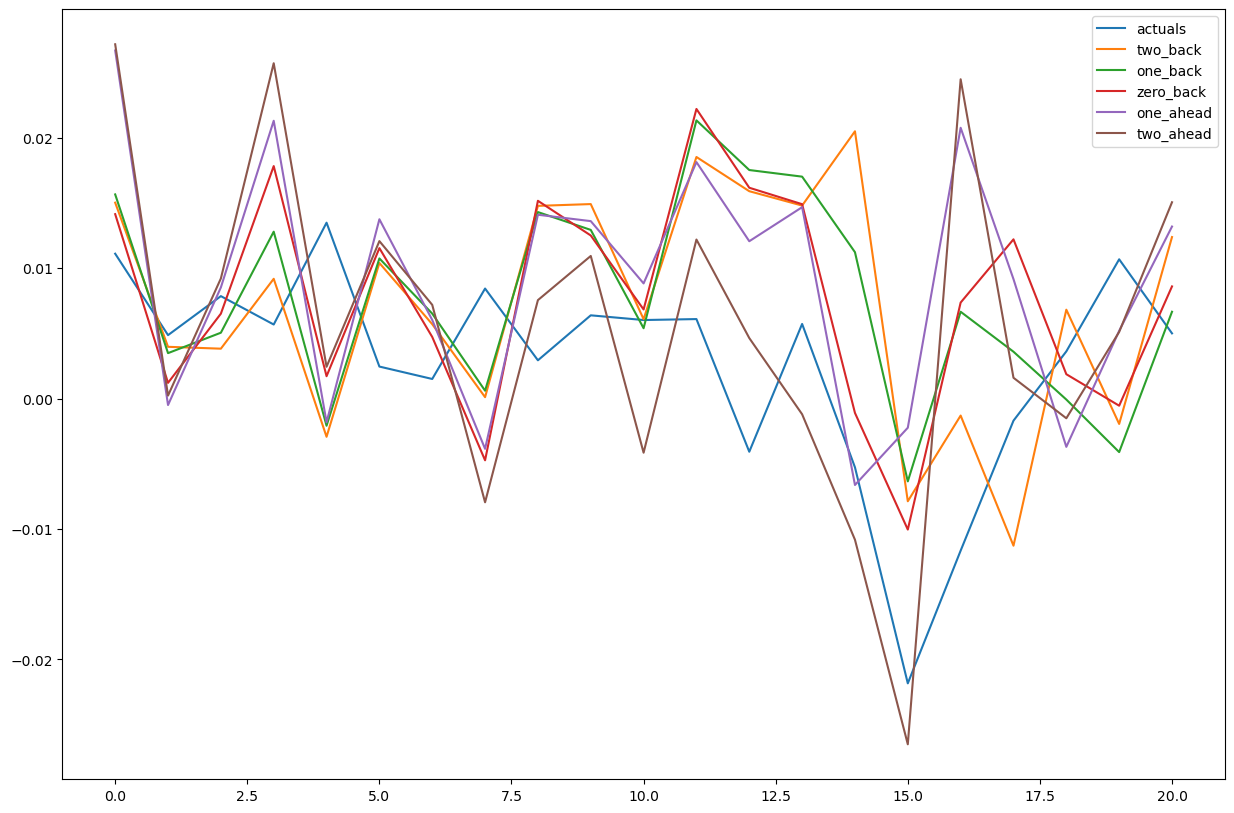

In [86]:
# plot of predictions vs actuals
pd.DataFrame({
    "actuals":actuals, 
    "two_back":pred_dict[-2], 
    "one_back":pred_dict[-1], 
    "zero_back":pred_dict[0],
    "one_ahead":pred_dict[1],
    "two_ahead":pred_dict[2]}
).plot()
;

# Final model usage / getting predictions on new data
Say model selection is finished and the model is to now be used, i.e. used to get predictions on new data.

In [81]:
# the test data ends 2010-03-01, let's say we wanted to predict 2010-06-01
new_data = test.copy()

# the date we want predicted must be in the date, if it's not there it must be added
desired_date = pd.to_datetime("2010-06-01")

while desired_date > np.max(new_data.date):
    new_data.loc[len(new_data), "date"] = np.max(new_data.date) + pd.DateOffset(months=1)

# we can now confirm the date we want to forecast is in the dataframe, even if all values are missing
new_data.tail()

,date,payems,gdpc1,cpiaucsl,dgorder,hsn1f,rsafs,unrate,houst,indpro,...,ir,cpilfesl,pcepilfe,pcepi,permit,tcu,businv,ulcnfb,iq,a261rx1q020sbea
757,2010-02-01,-0.000709,NaN,-0.000952,-0.003127,-0.026087,0.002289,0.000000,-0.016287,0.003535,...,-0.000794,0.000444,0.000873,-0.000031,0.022013,0.005553,0.006595,NaN,-0.003314,NaN
758,2010-03-01,0.001396,0.005001,0.000331,0.009410,0.133929,0.021696,0.010204,0.052980,0.007105,...,0.003975,0.000236,0.001496,0.001416,0.056923,0.009229,0.004449,-0.01191,0.007481,0.005757
759,2010-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
760,2010-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
761,2010-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [82]:
PRED_DATE = pd.to_datetime("2010-06-01")

# mean-fill (for inference you're ok using latest data itself)
transformed_new_data = mean_fill_dataset(new_data, new_data)

# IMPORTANT: use the same input_vars ordering the model was trained with
# (assuming you used this definition during training; otherwise keep a stored list)
input_vars = [c for c in transformed_new_data.columns if c not in ["date", target_variable]]

# Build logsig feature row using the *existing* scaler from the training loop
X_new = build_logsig_X_for_one_date(
    df_filled=transformed_new_data,
    input_vars=input_vars,
    end_date=PRED_DATE,
    L=L,              # must match training
    depth=DEPTH,      # must match training
    scaler=scaler,    # reuse training scaler
    add_time=True
)

if X_new.size == 0:
    raise ValueError(
        f"Cannot build logsig features for {PRED_DATE}: "
        f"need {L} months of history ending at that month and all months must exist."
    )

model.predict(X_new)[0]


np.float64(0.014384181706495143)

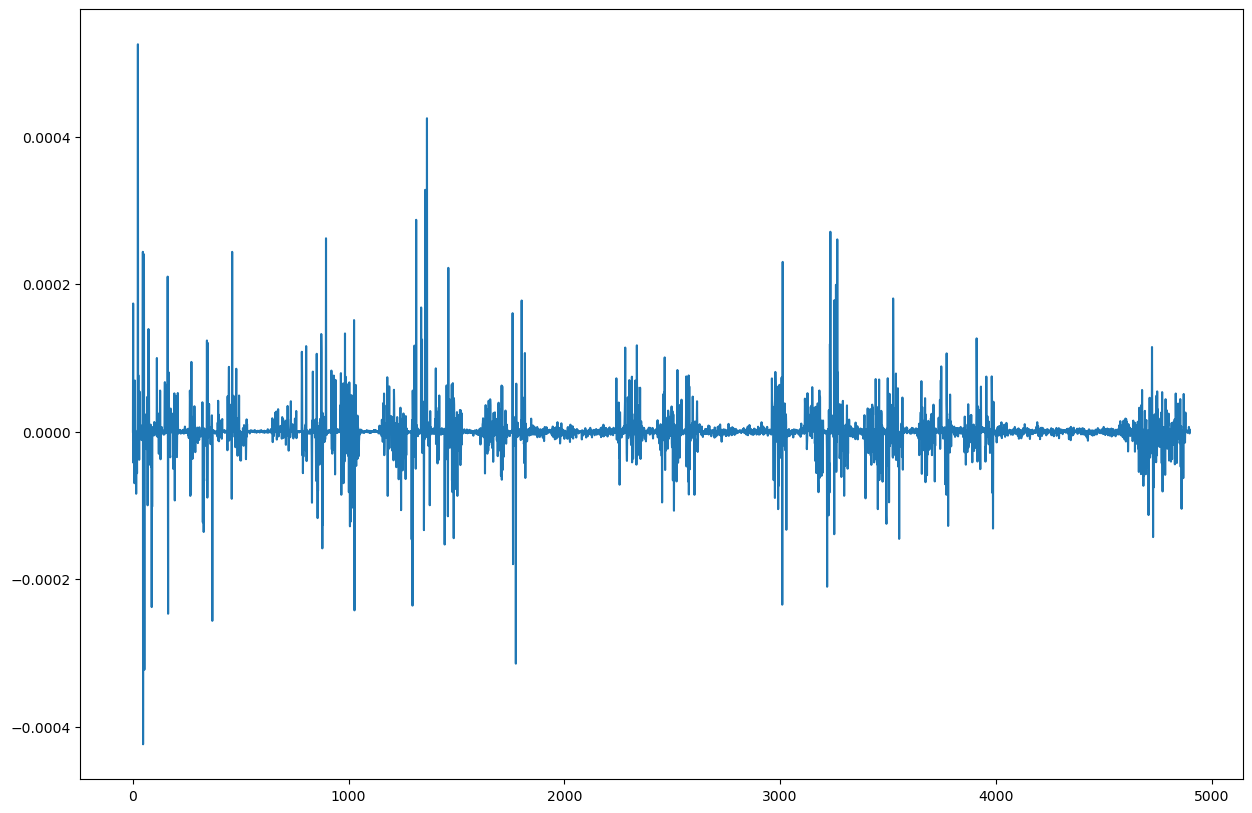

In [83]:
plt.plot(model.coef_)